# hw2: Решающие деревья

*Спасибо великому курсу великого Евгения Соколова*

### О задании

Задание состоит из двух разделов:
1. В первом разделе вы научитесь применять деревья из sklearn для задачи классификации. Вы посмотрите какие разделяющие поверхности деревья строят для различных датасетов и проанализируете их зависимость от различных гиперпараметров.
2. Во втором разделе вы попробуете реализовать свое решающее дерево и сравните его со стандартное имплементацией из sklearn. Вы также протестируете деревья на более сложных датасетах и сравните различные подходы к кодированию категориальных признаков.

Все данные, на которых будут обучаться модели, вы можете найти на диске.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Неэффективная и/или неоригинальная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Заполненный ноутбук ```hw2-trees.ipynb``` и модуль с реализованными функциями и классами ```hw2code.py``` необходимо загрузить на свой Github. Затем нужно оставить комментарий в Google-таблице с оценками в столбце <<hw2>> в строке со своей фамилией о том, что вы выполнили работу с указанием ника на Kaggle. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import Colormap, ListedColormap
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style='whitegrid')

import warnings
warnings.filterwarnings('ignore')

# 1. Решающие деревья. Визуализация.

В этой части мы рассмотрим два простых двумерных датасета сделанных с помощью `make_moons`, `make_circles` и посмотрим как ведет себя разделяющая поверхность в зависимости от различных гиперпараметров.

In [2]:
from sklearn.datasets import make_moons, make_circles, make_classification
datasets = [
    make_circles(noise=0.2, factor=0.5, random_state=42),
    make_moons(noise=0.2, random_state=42),
    make_classification(n_classes=3, n_clusters_per_class=1, n_features=2, class_sep=.8, random_state=3,
                        n_redundant=0)
]

In [3]:
palette = sns.color_palette(n_colors=3)
cmap = ListedColormap(palette)

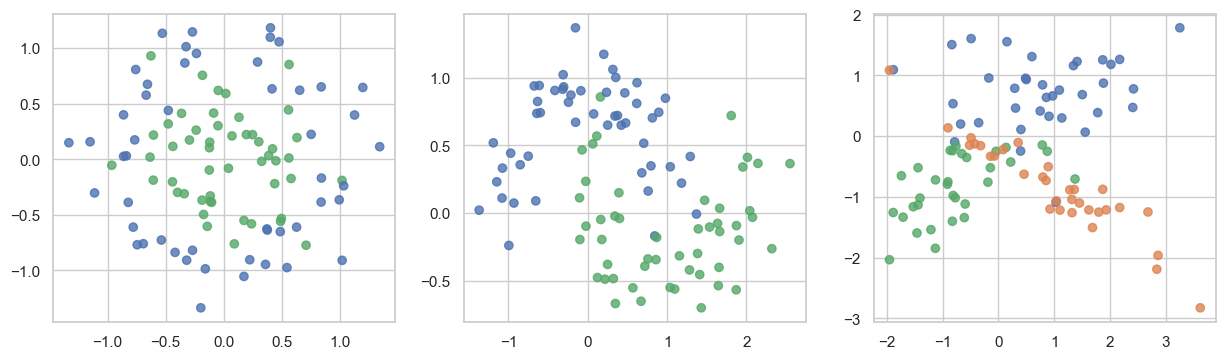

In [4]:
plt.figure(figsize=(15, 4))
for i, (x, y) in enumerate(datasets):
    plt.subplot(1, 3, i + 1)
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=cmap, alpha=.8)

__Задание 1. (1 балл)__

Для каждого датасета обучите решающее дерево с параметрами по умолчанию, предварительно разбив выборку на обучающую и тестовую. Постройте разделящие поверхности (для этого воспользуйтесь функцией `plot_surface`, пример ниже). Посчитайте accuracy на обучающей и тестовой выборках. Сильно ли деревья переобучились?

In [5]:
def plot_surface(clf, X, y):
    plot_step = 0.01
    palette = sns.color_palette(n_colors=len(np.unique(y)))
    cmap = ListedColormap(palette)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=.7,
                edgecolors=np.array(palette)[y], linewidths=2)

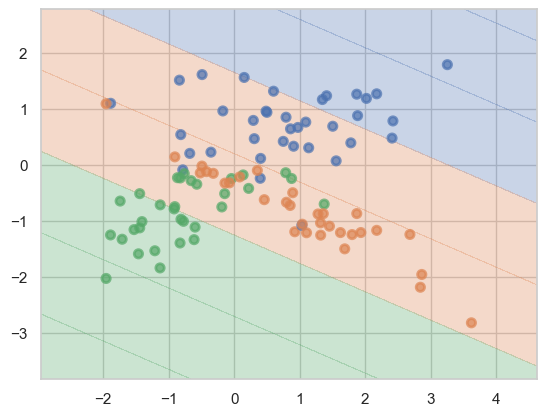

In [6]:
# Пример:
from sklearn.linear_model import LinearRegression
X, y = datasets[2]
lr  = LinearRegression().fit(X, y)
plot_surface(lr, X, y)

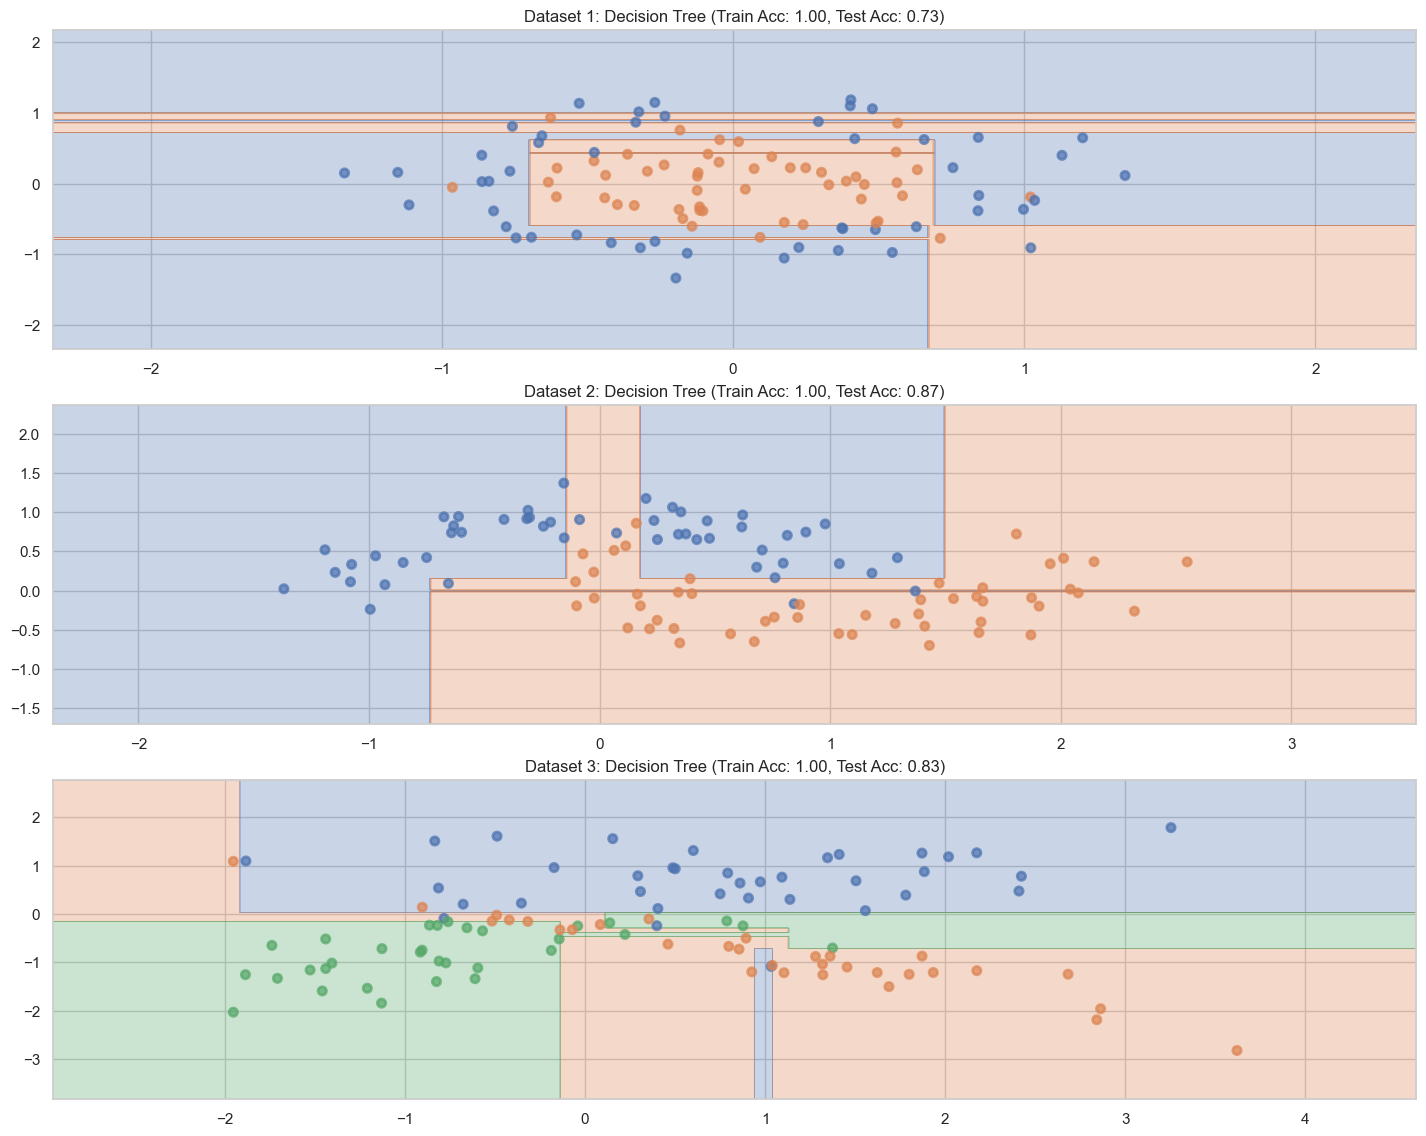

           Train Accuracy  Test Accuracy  Overfitting 
Dataset 1             1.0       0.733333      0.266667
Dataset 2             1.0       0.866667      0.133333
Dataset 3             1.0       0.833333      0.166667


In [7]:
results = {}

plt.figure(figsize=(15, 12))
for i, (X, y) in enumerate(datasets):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    clf = DecisionTreeClassifier(random_state=42)
    clf.fit(X_train, y_train)

    train_accuracy = clf.score(X_train, y_train)
    test_accuracy = clf.score(X_test, y_test)

    dataset_name = f'Dataset {i+1}'
    results[dataset_name] = {
        'Train Accuracy': train_accuracy,
        'Test Accuracy': test_accuracy,
        'Overfitting ': train_accuracy - test_accuracy
    }

    plt.subplot(3, 1, i + 1)
    plot_surface(clf, X, y)
    plt.title(f'{dataset_name}: Decision Tree (Train Acc: {train_accuracy:.2f}, Test Acc: {test_accuracy:.2f})')

plt.show()

results_df = pd.DataFrame(results).T
print(results_df)

__Ответ:__ Да, дерево переобучилось, так как точность на тренировочной выборке единица, а на тестовой заметно меньше

__Задание 2. (1.5 балла)__

Попробуйте перебрать несколько параметров для регуляризации (напр. `max_depth`, `min_samples_leaf`). Для каждого набора гиперпараметров постройте разделяющую поверхность, выведите обучающую и тестовую ошибки. Можно делать кросс-валидацию или просто разбиение на трейн и тест, главное делайте каждый раз одинаковое разбиение, чтобы можно было корректно сравнивать (помните же, что итоговое дерево сильно зависит от небольшого изменения обучающей выборки?). Проследите как меняется разделяющая поверхность и обобщающая способность. Почему так происходит, одинаково ли изменение для разных датасетов?

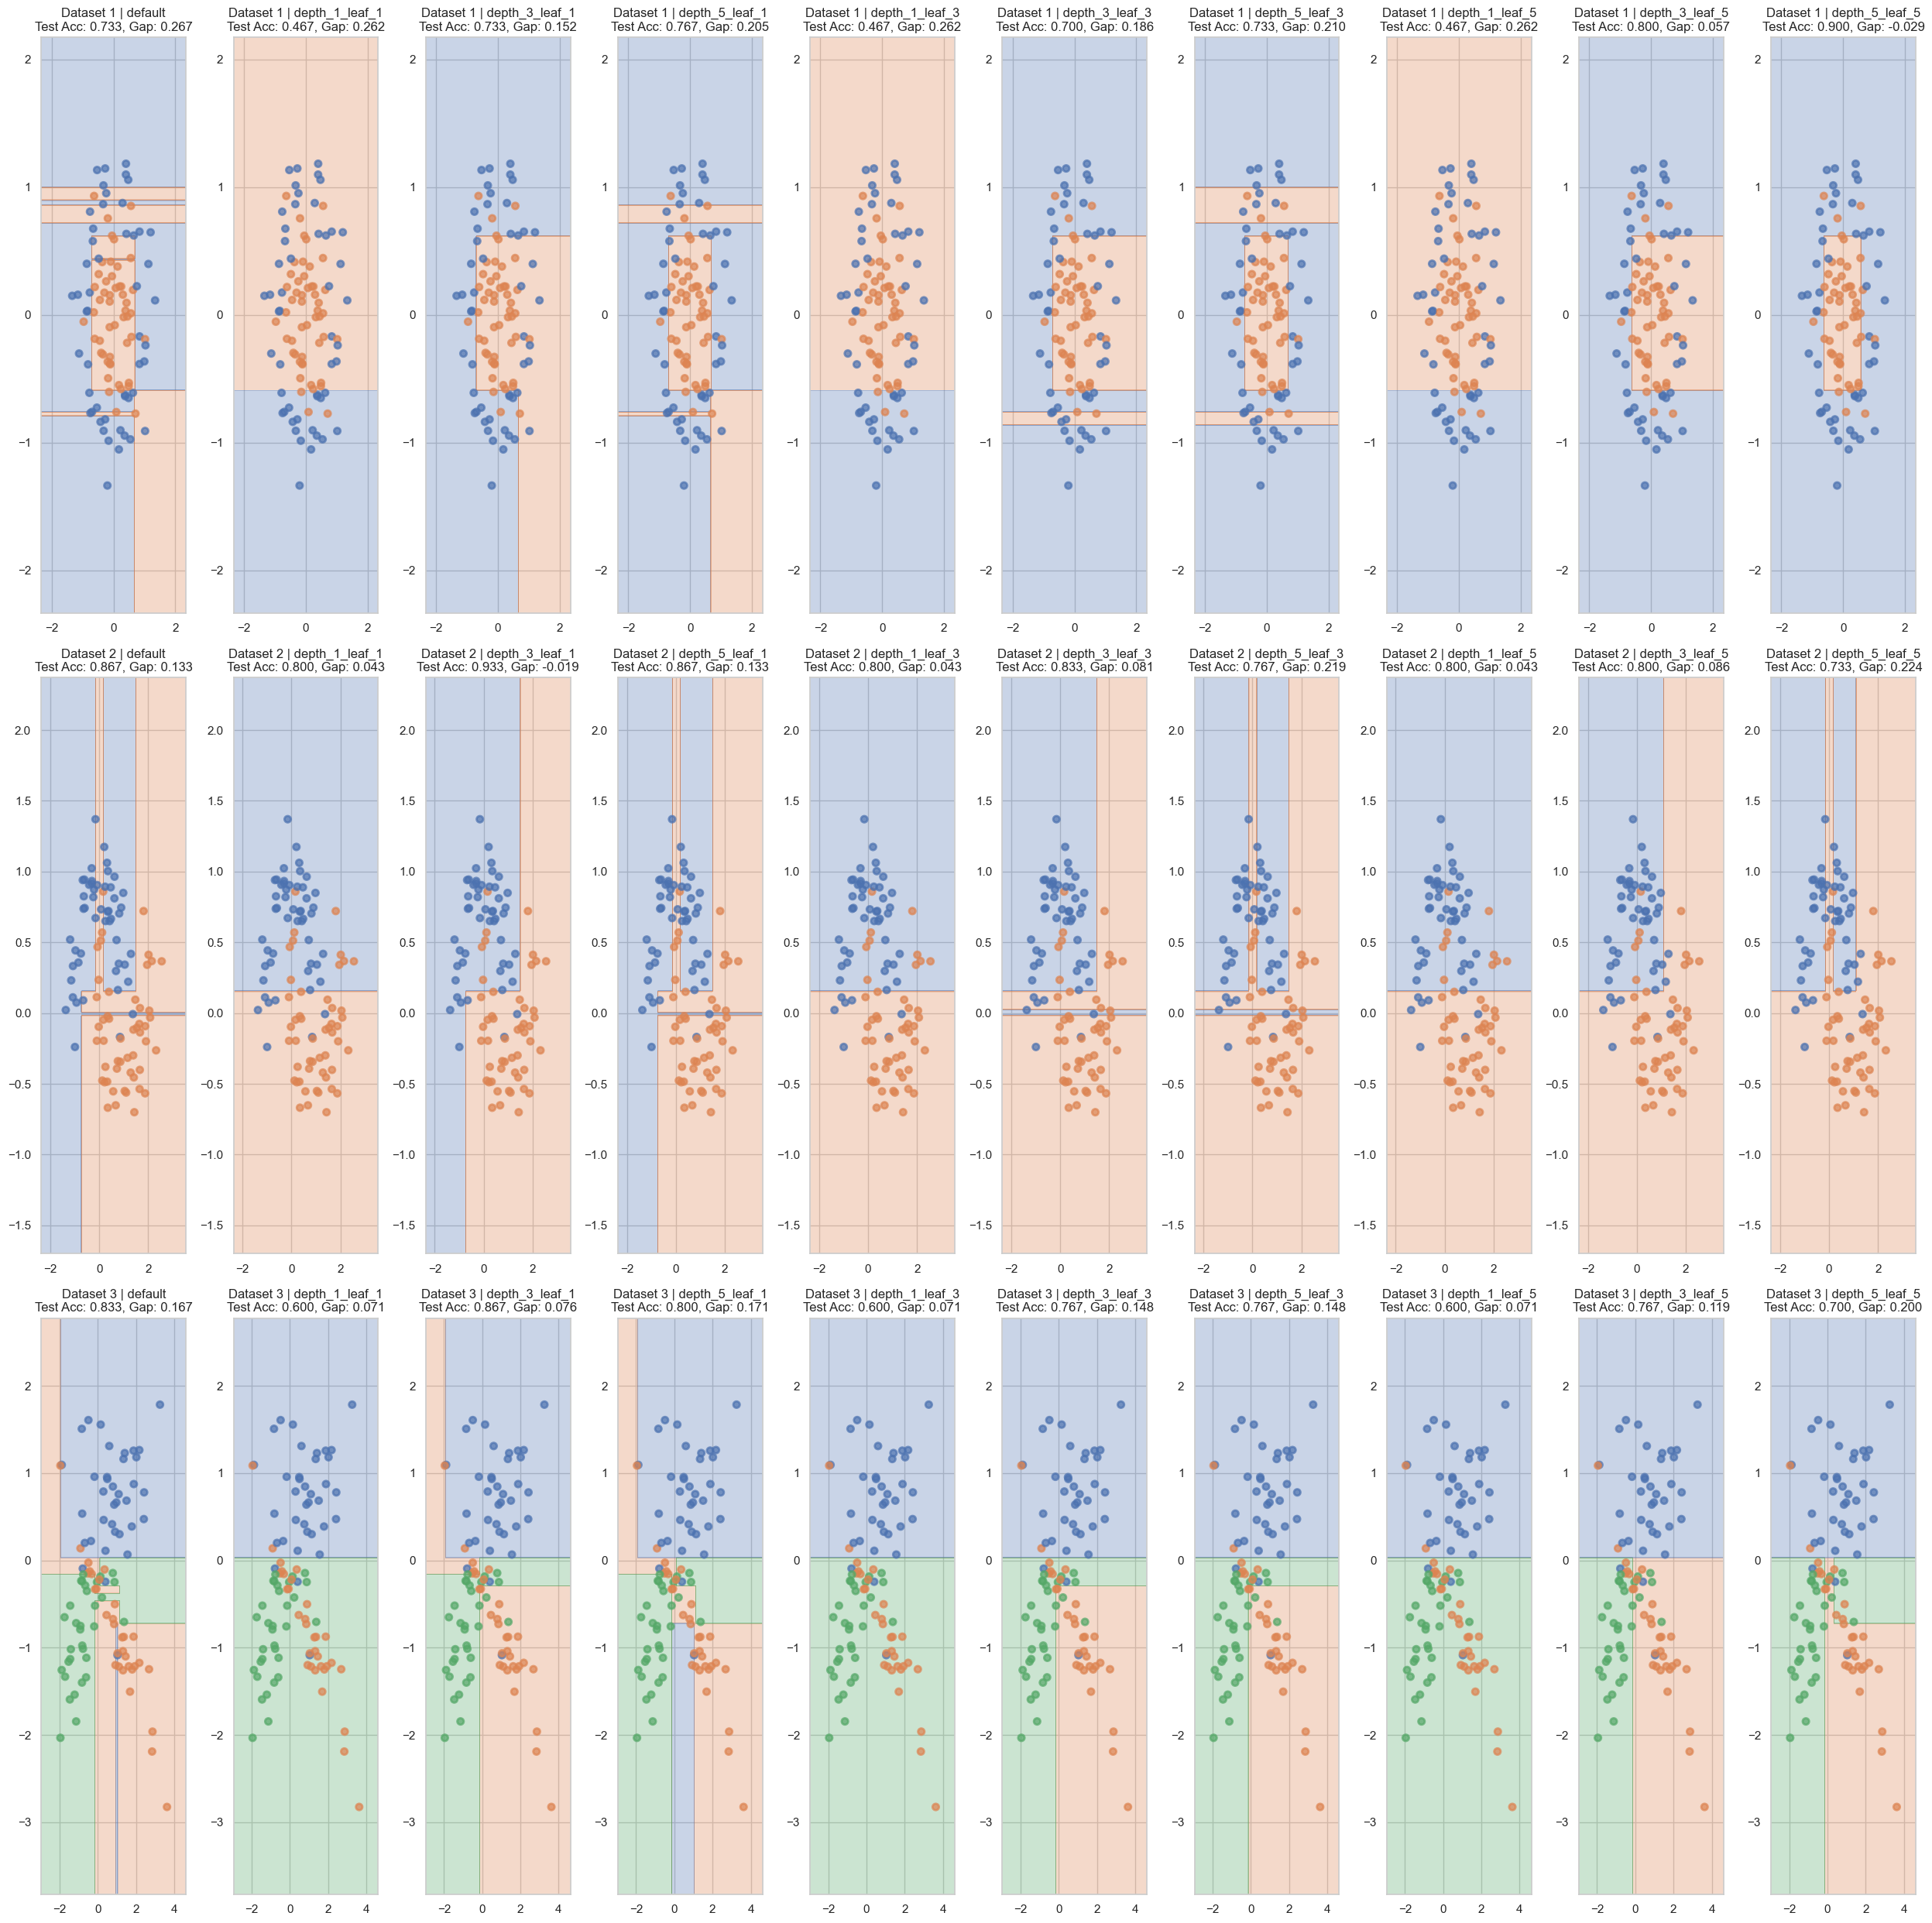

      Dataset          Params Train Acc. Test Acc.      Gap
0   Dataset 1         default     1.0000    0.7333   0.2667
1   Dataset 1  depth_1_leaf_1     0.7286    0.4667   0.2619
2   Dataset 1  depth_3_leaf_1     0.8857    0.7333   0.1524
3   Dataset 1  depth_5_leaf_1     0.9714    0.7667   0.2048
4   Dataset 1  depth_1_leaf_3     0.7286    0.4667   0.2619
5   Dataset 1  depth_3_leaf_3     0.8857    0.7000   0.1857
6   Dataset 1  depth_5_leaf_3     0.9429    0.7333   0.2095
7   Dataset 1  depth_1_leaf_5     0.7286    0.4667   0.2619
8   Dataset 1  depth_3_leaf_5     0.8571    0.8000   0.0571
9   Dataset 1  depth_5_leaf_5     0.8714    0.9000  -0.0286
10  Dataset 2         default     1.0000    0.8667   0.1333
11  Dataset 2  depth_1_leaf_1     0.8429    0.8000   0.0429
12  Dataset 2  depth_3_leaf_1     0.9143    0.9333  -0.0190
13  Dataset 2  depth_5_leaf_1     1.0000    0.8667   0.1333
14  Dataset 2  depth_1_leaf_3     0.8429    0.8000   0.0429
15  Dataset 2  depth_3_leaf_3     0.9143

In [8]:
param_sets = [
    {'name': 'default', 'max_depth': None, 'min_samples_leaf': 1},
    {'name': 'depth_1_leaf_1', 'max_depth': 1, 'min_samples_leaf': 1},
    {'name': 'depth_3_leaf_1', 'max_depth': 3, 'min_samples_leaf': 1},
    {'name': 'depth_5_leaf_1', 'max_depth': 5, 'min_samples_leaf': 1},
    {'name': 'depth_1_leaf_3', 'max_depth': 1, 'min_samples_leaf': 3},
    {'name': 'depth_3_leaf_3', 'max_depth': 3, 'min_samples_leaf': 3},
    {'name': 'depth_5_leaf_3', 'max_depth': 5, 'min_samples_leaf': 3},
    {'name': 'depth_1_leaf_5', 'max_depth': 1, 'min_samples_leaf': 5},
    {'name': 'depth_3_leaf_5', 'max_depth': 3, 'min_samples_leaf': 5},
    {'name': 'depth_5_leaf_5', 'max_depth': 5, 'min_samples_leaf': 5}
]


all_results = []
plot_idx = 1
plt.figure(figsize=(25, 25))

for d_idx, (X, y) in enumerate(datasets):
    dataset_name = f'Dataset {d_idx + 1}'
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    for p_idx, params in enumerate(param_sets):
        
        clf = DecisionTreeClassifier(
            max_depth=params['max_depth'], 
            min_samples_leaf=params['min_samples_leaf'], 
            random_state=42
        )
        clf.fit(X_train, y_train)

        train_acc = clf.score(X_train, y_train)
        test_acc = clf.score(X_test, y_test)
        overfit_gap = train_acc - test_acc

        all_results.append({
            'Dataset': dataset_name,
            'Params': params['name'],
            'Train Acc.': f'{train_acc:.4f}',
            'Test Acc.': f'{test_acc:.4f}',
            'Gap': f'{overfit_gap:.4f}'
        })

        plt.subplot(len(datasets), len(param_sets), plot_idx)
        plot_surface(clf, X, y)
        plt.title(f'{dataset_name} | {params["name"]}\nTest Acc: {test_acc:.3f}, Gap: {overfit_gap:.3f}')
        plot_idx += 1

plt.tight_layout()
plt.show()

results_df = pd.DataFrame(all_results)
print(results_df)

__Ответ:__ Без регуляризации разделяющая способность крайне сложная и извилистая, так как дерево стремится идеально классифицировать каждую точку обучающей выборки. Обобщающая способность такого дерева не высока, так как дерево переобучается.

С введением регуляризации поверхность становится заметно более гладкой и менее детализированной. Дерево не может бесконечно дробить пространство, и его решения становятся более обобщающими, фокусируясь на главных границах между классами.

Лучшие значения точности предсказания для датасетов получились при:
1 датасет - max_depth 5, min_samples_leaf 5
2 датасет - max_depth 3, min_samples_leaf 1
3 датасет - max_depth 3, min_samples_leaf 1

# 2. Решающие деревья своими руками

В этой части вам нужно реализовать свой класс для обучения решающего дерева в задаче бинарной классификации с возможностью обработки вещественных и категориальных признаков.

__Задание 3. (1.5 балл)__

Реализуйте функцию find_best_split из модуля hw2code.py

__Задание 4. (0.5 балла)__

Загрузите таблицу students.csv (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте scatter-графики "значение признака — класс" для всех пяти признаков.

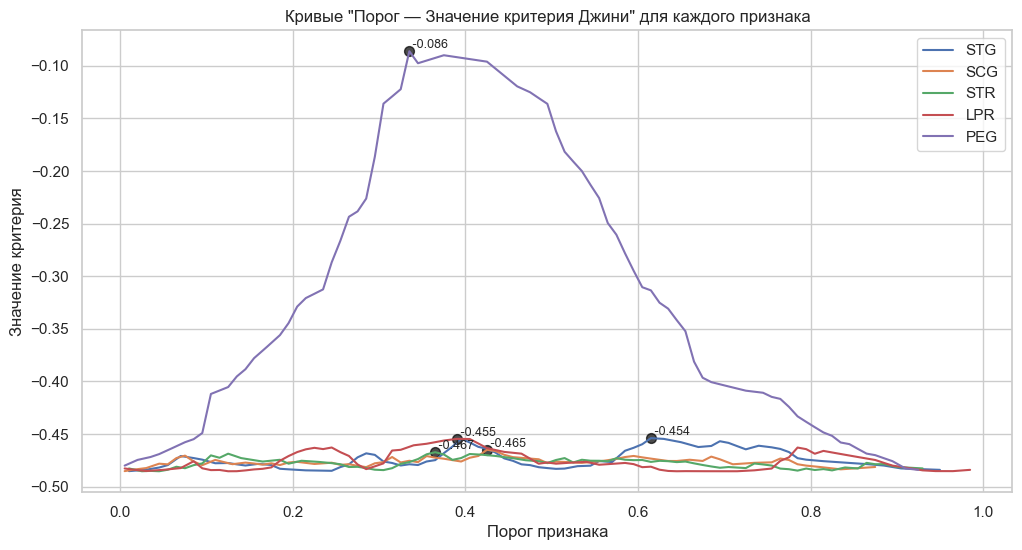

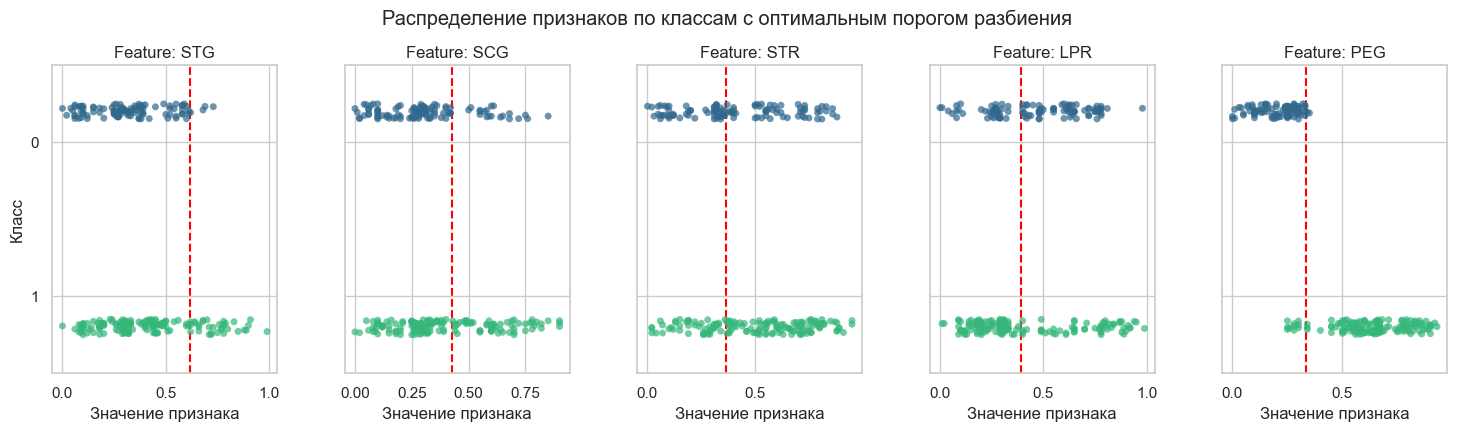

In [9]:
from hw2code import find_best_split

df = pd.read_csv("./datasets/students.csv")

X = df.iloc[:, :-1]
y = df.iloc[:, -1]
feature_names = X.columns

plt.figure(figsize=(12, 6))
best_splits = {}

for feature in feature_names:
    feature_vector = X[feature].values
    target_vector = y.values
    
    thresholds, ginis, threshold_best, gini_best = find_best_split(feature_vector, target_vector)
    
    if len(thresholds) > 0:
        plt.plot(thresholds, ginis, label=f'{feature}')
        
        best_splits[feature] = (threshold_best, gini_best)
        plt.scatter(threshold_best, gini_best, marker='o', s=50, color='black', alpha=0.7)
        plt.text(threshold_best, gini_best, f' {gini_best:.3f}', fontsize=9, verticalalignment='bottom')

plt.xlabel('Порог признака')
plt.ylabel('Значение критерия')
plt.title('Кривые "Порог — Значение критерия Джини" для каждого признака')
plt.legend()
plt.grid(True)
plt.show()

num_features = len(feature_names)
fig, axes = plt.subplots(1, num_features, figsize=(18, 4), sharey=True)
plt.subplots_adjust(wspace=0.3)

for i, feature in enumerate(feature_names):
    ax = axes[i]
    sns.stripplot(x=df[feature], y=df['UNS'], ax=ax, hue=df['UNS'], 
                  palette='viridis', dodge=True, alpha=0.7, orient='h')
    
    ax.set_title(f'Feature: {feature}')
    ax.set_xlabel('Значение признака')
    ax.set_ylabel('Класс' if i == 0 else '')
    
    best_t = best_splits[feature][0]
    ax.axvline(best_t, color='red', linestyle='--', linewidth=1.5, label=f'Best Threshold: {best_t:.3f}')
    
    ax.legend([], [], frameon=False)
    ax.grid(axis='y')

plt.suptitle('Распределение признаков по классам с оптимальным порогом разбиения', y=1.02)
plt.show()

__Задание 5. (0.5 балла)__

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой scatter-графиков? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

**Ответ:** Деление выборки на 2 поддерева следует производить по PEG так как он имеет максимальное значение критерия Q(R).
Данный результат полностью согласуется с визуальной оценкой scatter-графиков, объекты классов лучше всего визуально разделены на 2 части.
Кривая для хороших признаков должна иметь ярко выраженный максимум, должна напоминать нормальное распределение.
Кривые для плохих признаков имеют низкое значение максимума, плоский график без явного максимума.

__Задание 6. (1.5 балла).__

Разберитесь с уже написанным кодом в классе DecisionTree модуля hw2code.py. Найдите ошибки в реализации метода \_fit_node. Напишите функцию \_predict_node.

 Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции. Выбор лучшего разбиения необходимо производить по критерию Джини. Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку. Ответ в листе: наиболее часто встречающийся класс в листе. Для категориальных признаков выполняется преобразование, описанное в лекции в разделе «Учет категориальных признаков».

__Задание 7. (0.5 балла)__

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (лежит на гитхабе вместе с заданием), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [10]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from hw2code import DecisionTree


df = pd.read_csv("./datasets/agaricus-lepiota.data", header=None)
    

X_df = df.iloc[:, 1:] 
y_df = df.iloc[:, 0] 

encoders = {}
for col in df.columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le

X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

feature_types = ["categorical"] * X.shape[1]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=42, stratify=y
)

dt = DecisionTree(feature_types=feature_types)
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.6f}")

def get_tree_depth(node):
    if node.get("type") == "terminal":
        return 1
    
    left_depth = get_tree_depth(node["left_child"])
    right_depth = get_tree_depth(node["right_child"])
    
    return 1 + max(left_depth, right_depth)

tree_depth = get_tree_depth(dt._tree)
print(f"depth: {tree_depth}")

Accuracy: 1.000000
depth: 8


__Задание 8. (бонус, 1 балл)__

Реализуйте в классе DecisionTree поддержку параметров max_depth, min_samples_split и min_samples_leaf по аналогии с DecisionTreeClassifier. Постройте графики зависимости качества предсказания в зависимости от этих параметров для набора данных tic-tac-toe (см. следующий пункт).

__Задание 9. (2 балла)__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names): 
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце)
* [tic-tac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце, датасет лежит на гитхабе вместе с заданием)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc — это класс 0, good, vgood — класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend — класс 0, very_recom, priority, spec_prior — класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTree, считающий все признаки вещественными
* DecisionTree, считающий все признаки категориальными
* DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
* DecisionTreeClassifier из sklearn. Запишите результат в pd.DataFrame (по строкам — наборы данных, по столбцам — алгоритмы).

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder (если вы, конечно, используете его). Иначе вам придется добиваться того, чтобы ваша реализация дерева умела работать с разреженными матрицами (что тоже, в целом, не очень сложно).

In [12]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeClassifier


df = pd.read_csv("./datasets/agaricus-lepiota.data", header=None)

for col in df.columns:
    df[col] = LabelEncoder().fit_transform(df[col])
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values
mushrooms = (X, y)


df = pd.read_csv("./datasets/tic-tac-toe-endgame.csv", header=None)
X = df.iloc[:, :-1].apply(LabelEncoder().fit_transform).values
y = LabelEncoder().fit_transform(df.iloc[:, -1].values)
tic_tac_toe = (X, y)

cols = ["buying", "maint", "doors", "persons", "lug_boot", "safety", "class"]
df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data", names=cols
)
df["class"] = df["class"].map(lambda v: 0 if v in ("unacc", "acc") else 1)
X = df.iloc[:, :-1].apply(LabelEncoder().fit_transform).values
y = df["class"].values
cars = (X, y)

cols = ["parents", "has_nurs", "form", "children", "housing", "finance", "social", "health", "class"]
df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/nursery/nursery.data",
    names=cols,
)
df["class"] = df["class"].map(lambda v: 0 if v in ("not_recom", "recommend") else 1)
X = df.iloc[:, :-1].apply(LabelEncoder().fit_transform).values
y = df["class"].values
nursery = (X, y)


datasets = {
    "mushrooms": mushrooms,
    "tic-tac-toe": tic_tac_toe,
    "cars": cars,
    "nursery": nursery,
}

In [15]:
def get_ohe_data(X):
    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    return ohe.fit_transform(X)

datasets_ohe = {}
for name, (X, y) in datasets.items():
    datasets_ohe[name] = (get_ohe_data(X), y)

scoring_metric = make_scorer(accuracy_score)
cv_strategy = KFold(n_splits=10, shuffle=True, random_state=42)
results = {}

for name in datasets:
    X_label, y = datasets[name]
    X_ohe, _ = datasets_ohe[name]
    
    N_features_label = X_label.shape[1]
    N_features_ohe = X_ohe.shape[1]

    dt_real = DecisionTree(feature_types=['real'] * N_features_label)
    score_dt_real = cross_val_score(
        dt_real, X_label, y, cv=cv_strategy, scoring=scoring_metric
    ).mean()

    dt_cat = DecisionTree(feature_types=['categorical'] * N_features_label)
    score_dt_cat = cross_val_score(
        dt_cat, X_label, y, cv=cv_strategy, scoring=scoring_metric
    ).mean()

    dt_ohe_real = DecisionTree(feature_types=['real'] * N_features_ohe)
    score_dt_ohe_real = cross_val_score(
        dt_ohe_real, X_ohe, y, cv=cv_strategy, scoring=scoring_metric
    ).mean()

    sklearn_dt = DecisionTreeClassifier(random_state=42)
    score_sklearn = cross_val_score(
        sklearn_dt, X_label, y, cv=cv_strategy, scoring=scoring_metric
    ).mean()

    results[name] = {
        'DT (LabelEncoder + real)': score_dt_real,
        'DT (LabelEncoder + categorical)': score_dt_cat,
        'DT (OHE + real)': score_dt_ohe_real,
        'DecisionTreeClassifier (sklearn)': score_sklearn
    }

results_df = pd.DataFrame(results).T

print(results_df.round(4))


             DT (LabelEncoder + real)  DT (LabelEncoder + categorical)  \
mushrooms                      1.0000                           1.0000   
tic-tac-toe                    0.8759                           0.9500   
cars                           0.9902                           0.9873   
nursery                        0.9998                           0.9998   

             DT (OHE + real)  DecisionTreeClassifier (sklearn)  
mushrooms             1.0000                            1.0000  
tic-tac-toe           0.9500                            0.8811  
cars                  0.9879                            0.9907  
nursery               0.9998                            0.9997  


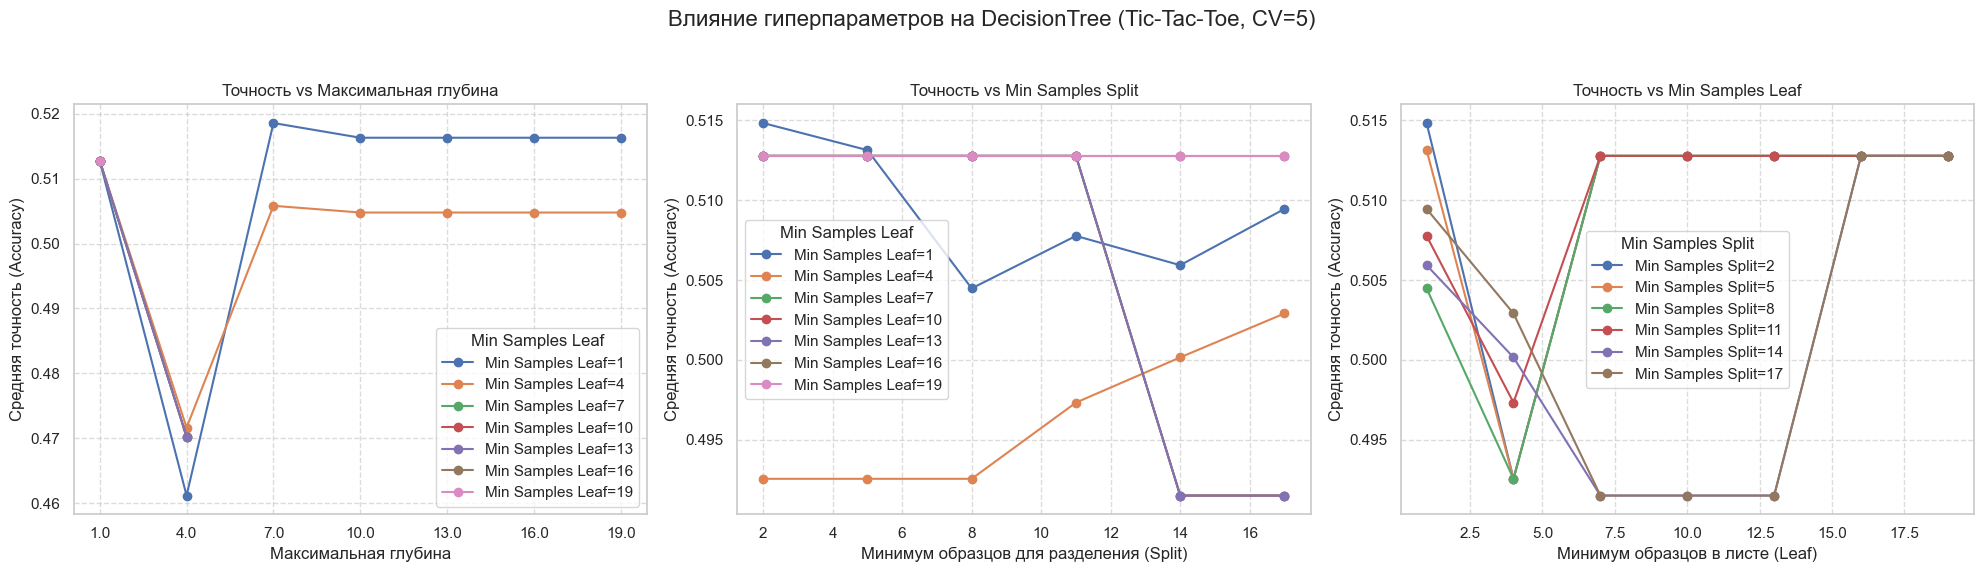

In [ ]:
from itertools import product

df = pd.read_csv("datasets/tic-tac-toe-endgame.csv")

X = df.iloc[:, :-1].apply(LabelEncoder().fit_transform)
y = LabelEncoder().fit_transform(df.iloc[:, -1].values)

feature_types = ['categorical'] * X.shape[1] 

params = {
    'max_depth': [None] + list(range(1, 20, 3)),
    'min_samples_split': list(range(2, 20, 3)),
    'min_samples_leaf': list(range(1, 20, 3))
}


results = []
param_combinations = product(
    params['max_depth'], 
    params['min_samples_split'], 
    params['min_samples_leaf']
)


for depth, split, leaf in param_combinations:
    tree = DecisionTree(
        feature_types,
        max_depth=depth,
        min_samples_split=split,
        min_samples_leaf=leaf
    )
    
    scores = cross_val_score(tree, X.values, y, cv=5, scoring='accuracy')
    
    results.append({
        'max_depth': depth,
        'min_samples_split': split,
        'min_samples_leaf': leaf,
        'accuracy_mean': scores.mean()
    })

res = pd.DataFrame(results)

def plot_accuracy_dependence(df_results, group_by_param, varying_param, ax, title_suffix, x_label):
    grouping_values = df_results[group_by_param].unique()
    
    for val in grouping_values:
        sub = df_results[df_results[group_by_param] == val]
        
        means = sub.groupby(varying_param)['accuracy_mean'].mean()
        
        x_values = [str(x) for x in means.index] if varying_param == 'max_depth' else means.index.values

        label = f"{group_by_param.replace('_', ' ').title()}={val}"
        ax.plot(x_values, means.values, marker='o', label=label)

    ax.set_xlabel(x_label)
    ax.set_ylabel("Средняя точность")
    ax.set_title(title_suffix)
    ax.legend(title=group_by_param.replace('_', ' ').title(), loc='best')
    ax.grid(True, linestyle='--', alpha=0.7)


fig, axes = plt.subplots(1, 3, figsize=(20, 6))

plot_accuracy_dependence(
    res, 'min_samples_leaf', 'max_depth', axes[0], 
    "Точность vs Максимальная глубина", "Максимальная глубина"
)

plot_accuracy_dependence(
    res, 'min_samples_leaf', 'min_samples_split', axes[1], 
    "Точность vs Min Samples Split", "Минимум образцов для разделения"
)

plot_accuracy_dependence(
    res, 'min_samples_split', 'min_samples_leaf', axes[2], 
    "Точность vs Min Samples Leaf", "Минимум образцов в листе"
)

plt.suptitle('Влияние гиперпараметров на DecisionTree', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

__Задание 10. (1 балла)__

Проанализируйте результаты эксперимента. 
Одинаково ли для разных наборов данных ранжируются алгоритмы? 
Порассуждайте, почему так происходит. 

Обратите внимание на значение признаков в разных наборах данных. 
Присутствует ли в результатах какая-то компонента случайности? 
Можно ли повлиять на нее и улушить работу алгоритмов?

**Ответ:** Алгоритмы ранжируются по разному из за различий в датасетах.
Mushrooms - линейно разделимый датасет, потому модель легко находит закономерности, ограничения только мешают.
Cars, nursey - умеренно сложный датасет, ограничения должны быть умеренные для хорошей обобщающей способности.
Tic-tac-toe - сложный датасет, модель переобучается и плохо предсказывает.

Результаты зависят от конкретного random_state.
На случайность можно повлиять:
1) Кросс-валидация
2) Многократные запуски с разными random_state

Вставьте что угодно, описывающее ваши впечатления от этого задания: